In [3]:
%load_ext IPython.extensions.autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The IPython.extensions.autoreload extension is already loaded. To reload it, use:
  %reload_ext IPython.extensions.autoreload


In [4]:
import sys
sys.path.append('../..')
from model import FinData
from model import train_valid_split
from model import CatboostFinModel
from backtests import Backtest

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pandas as pd

In [10]:
args = {"iterations" : 5000, 
        "depth" : 5, 
        "learning_rate" : 0.02, 
        "use_best_model" : True, 
        "l2_leaf_reg" : 100,
        "loss_function" : 'Logloss', 
        "eval_metric" : 'Logloss', 
        "cat_features" : [], 
        "class_weights" : [1, 0.4],
        "random_state" : 42,
        "early_stopping_rounds" : 500}

args1 = {"iterations" : 10000, 
        "depth" : 5, 
        "learning_rate" : 0.02, 
        "use_best_model" : True, 
        "l2_leaf_reg" : 200,
        "loss_function" : 'Logloss', 
        "eval_metric" : 'Logloss', 
        "cat_features" : [], 
        "class_weights" : [1, 0.25],
        "random_state" : 42,
        "verbose" : 0, 
        "early_stopping_rounds" : 500}

args0 = {"iterations" : 10000, 
        "depth" : 5, 
        "learning_rate" : 0.02, 
        "use_best_model" : True, 
        "l2_leaf_reg" : 200,
        "loss_function" : 'Logloss', 
        "eval_metric" : 'Logloss', 
        "cat_features" : [], 
        "class_weights" : [0.25, 1],
        "random_state" : 42,
        "verbose" : 0, 
        "early_stopping_rounds" : 500}

In [25]:
companies_names = ['Gazprom']
dfs = ["../../datasets/" + stock + '_1_min.csv' for stock in companies_names]

dfs_dict = dict()
start_dt = dt.datetime(2024, 1, 1)

for i in range(len(dfs)):
    findata = FinData(dfs[i])
    findata.restrict_time_down(start_dt)
    findata.insert_all()
    cat = findata.get_cat_features()
    num = findata.get_numeric_features()
    find = findata.df[findata.df['utc'].dt.hour >= 7][findata.df['utc'].dt.hour < 20]
    dfs_dict[companies_names[i]] = find 

backtest = Backtest(strategies=['long'], args=args, dfs=dfs_dict, features = [cat, num], comissions=[0.0004])

backtest_args = {
    'budget': 10000,
    'train_size': dt.timedelta(days=30),
    'val_size': dt.timedelta(days=5),
    'test_size':dt.timedelta(days=5),
    'start_dt_test': dt.datetime(2024, 4, 1),
    'end_dt_test': dt.datetime(2024, 4, 20),
    'args_for_strategies': {'long': (args1, 'direction_binary_0'), 'short': (args0, 'direction_binary_1')}
}
results = backtest.test_trading_long_short(**backtest_args)


2025-05-22 16:16:56,131 - INFO - Starting backtesting for stock: Gazprom
2025-05-22 16:16:58,009 - INFO - Round 1 - Train: 2024-02-26 07:00:00 to 2024-03-26 19:59:00, Validation: 2024-03-27 07:00:00 to 2024-03-31 15:59:00, Test: 2024-04-01 07:00:00 to 2024-04-05 19:59:00
2025-05-22 16:17:27,578 - INFO - Model 0 (short) trained.
2025-05-22 16:18:00,035 - INFO - Model 1 (long) trained.
2025-05-22 16:19:40,588 - INFO - My budget on round - 1 before 10000 and after trading 10000

2025-05-22 16:19:40,824 - INFO - Metrics for round 1 - Stock: Gazprom
2025-05-22 16:19:40,826 - INFO - Short model val loss: 0.36948700044724125, Long model val loss: 0.35599862606610755
2025-05-22 16:19:42,768 - INFO - Round 2 - Train: 2024-03-02 07:01:00 to 2024-03-31 15:59:00, Validation: 2024-04-01 07:00:00 to 2024-04-05 19:59:00, Test: 2024-04-06 07:01:00 to 2024-04-10 19:59:00
2025-05-22 16:20:35,553 - INFO - Model 0 (short) trained.
2025-05-22 16:21:16,449 - INFO - Model 1 (long) trained.
2025-05-22 16:21:1

In [16]:
results[0][1]

IndexError: list index out of range

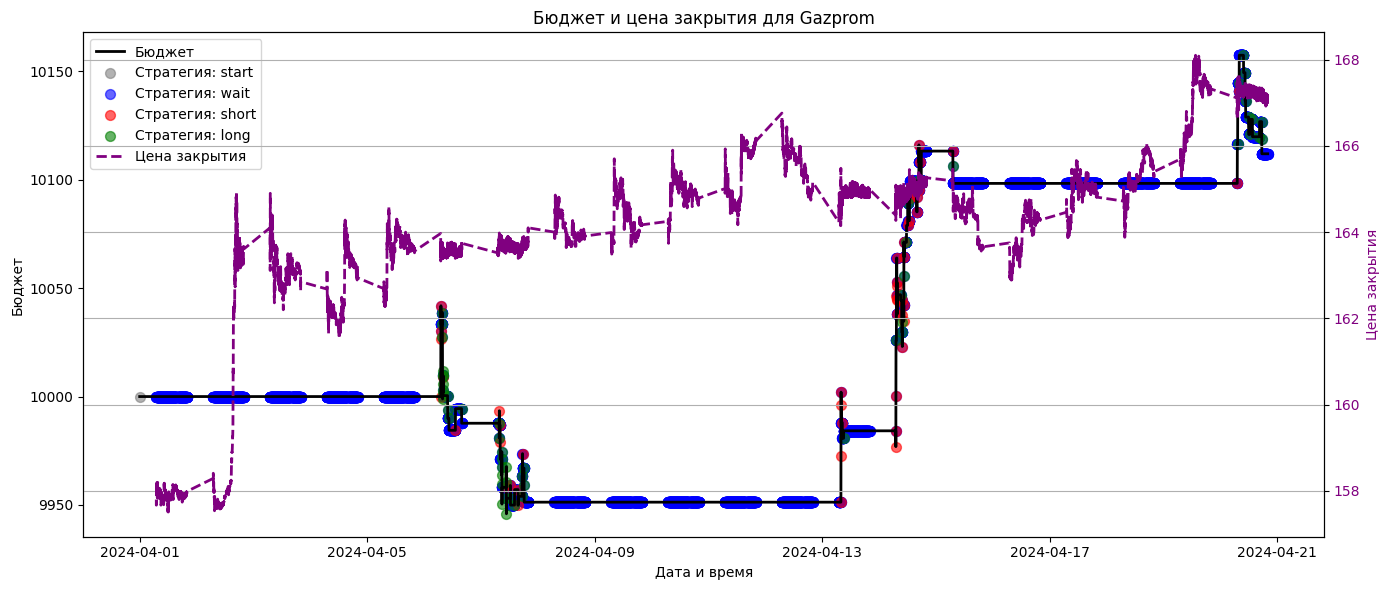

In [17]:
# История бюджета
history = results[0][0].copy()
history['datetime'] = pd.to_datetime(history['datetime'])
history = history.sort_values('datetime')

# Цены закрытия из исходного DataFrame (df) той же компании
# Найдём компанию
company_name = companies_names[0]
df_close = dfs_dict[company_name].copy()
df_close = df_close[df_close['utc'].between(history['datetime'].min(), history['datetime'].max())]
df_close = df_close.sort_values('utc')

fig, ax1 = plt.subplots(figsize=(14, 6))

# Первая ось — бюджет
ax1.set_xlabel('Дата и время')
ax1.set_ylabel('Бюджет', color='black')
ax1.plot(history['datetime'], history['budget'], label='Бюджет', color='black', linewidth=2)

# Точки стратегии
colors = {'start': 'gray', 'wait': 'blue', 'long': 'green', 'short': 'red'}
for strategy in history['strategy'].unique():
    mask = history['strategy'] == strategy
    ax1.scatter(history.loc[mask, 'datetime'], history.loc[mask, 'budget'],
                label=f'Стратегия: {strategy}', color=colors.get(strategy, 'black'), s=50, alpha=0.6)

ax1.tick_params(axis='y', labelcolor='black')

# Вторая ось — цена закрытия
ax2 = ax1.twinx()
ax2.set_ylabel('Цена закрытия', color='purple')
ax2.plot(df_close['utc'], df_close['close'], color='purple', linestyle='--', linewidth=2, label='Цена закрытия')
ax2.tick_params(axis='y', labelcolor='purple')

# Объединение легенд
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title(f'Бюджет и цена закрытия для {company_name}')
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
news_df = pd.read_csv('../../markettwits_with_hashtags.csv')

dfs_dict = dict()
start_dt = dt.datetime(2024, 1, 1)

for i in range(len(dfs)):
    findata = FinData(dfs[i])
    findata.restrict_time_down(start_dt)
    findata.insert_all()
    findata.insert_news_features(news_df, threshold=0.6)
    findata.make_both_binary_class_target()
    cat = findata.get_cat_features()
    num = findata.get_numeric_features()
    find = findata.df[findata.df['utc'].dt.hour >= 7][findata.df['utc'].dt.hour < 20]
    dfs_dict[companies_names[i]] = find 

backtest = Backtest(strategies=['long'], args=args, dfs=dfs_dict, features = [cat, num], comissions=[0.0004])

backtest_args = {
    'budget': 10000,
    'train_size': dt.timedelta(days=30),
    'val_size': dt.timedelta(days=5),
    'test_size':dt.timedelta(days=5),
    'start_dt_test': dt.datetime(2024, 4, 1),
    'end_dt_test': dt.datetime(2024, 4, 20),
    'args_for_strategies': {'long': (args1, 'direction_binary_0'), 'short': (args0, 'direction_binary_1')}
}
results_news_small = backtest.test_trading_long_short(**backtest_args)


2025-05-22 14:55:15,711 - INFO - Starting backtesting for stock: Gazprom
2025-05-22 14:55:17,516 - INFO - Round 1 - Train: 2024-02-26 07:00:00 to 2024-03-26 19:59:00, Validation: 2024-03-27 07:00:00 to 2024-03-31 15:59:00, Test: 2024-04-01 07:00:00 to 2024-04-05 19:59:00
2025-05-22 14:57:03,283 - INFO - Model 0 (short) trained.
2025-05-22 14:58:58,005 - INFO - Model 1 (long) trained.
2025-05-22 15:00:32,209 - INFO - My budget on round - 1 before 10000 and after trading 10000

2025-05-22 15:00:32,360 - INFO - Metrics for round 1 - Stock: Gazprom
2025-05-22 15:00:32,360 - INFO - Short model val loss: 0.36934516070752715, Long model val loss: 0.3555499665758634
2025-05-22 15:00:34,481 - INFO - Round 2 - Train: 2024-03-02 07:01:00 to 2024-03-31 15:59:00, Validation: 2024-04-01 07:00:00 to 2024-04-05 19:59:00, Test: 2024-04-06 07:01:00 to 2024-04-10 19:59:00
2025-05-22 15:02:09,905 - INFO - Model 0 (short) trained.
2025-05-22 15:04:40,711 - INFO - Model 1 (long) trained.
2025-05-22 15:04:40

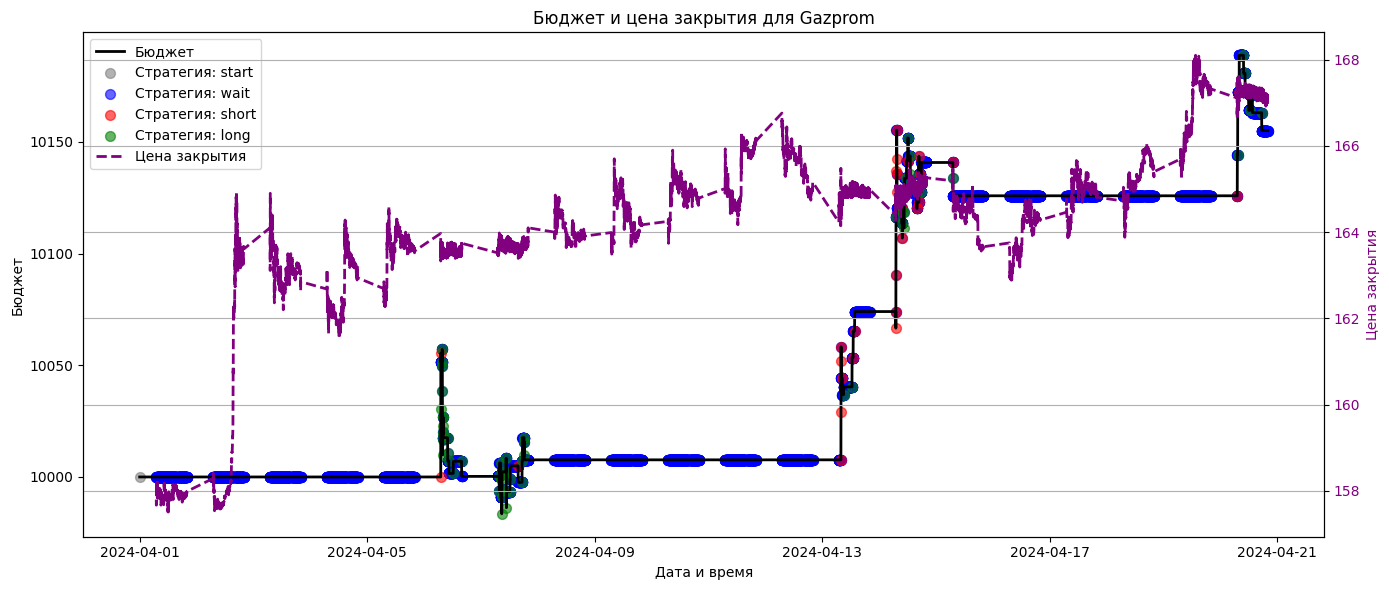

In [23]:
# История бюджета
history = results_news_small[0][0].copy()
history['datetime'] = pd.to_datetime(history['datetime'])
history = history.sort_values('datetime')

# Цены закрытия из исходного DataFrame (df) той же компании
# Найдём компанию
company_name = companies_names[0]
df_close = dfs_dict[company_name].copy()
df_close = df_close[df_close['utc'].between(history['datetime'].min(), history['datetime'].max())]
df_close = df_close.sort_values('utc')

fig, ax1 = plt.subplots(figsize=(14, 6))

# Первая ось — бюджет
ax1.set_xlabel('Дата и время')
ax1.set_ylabel('Бюджет', color='black')
ax1.plot(history['datetime'], history['budget'], label='Бюджет', color='black', linewidth=2)

# Точки стратегии
colors = {'start': 'gray', 'wait': 'blue', 'long': 'green', 'short': 'red'}
for strategy in history['strategy'].unique():
    mask = history['strategy'] == strategy
    ax1.scatter(history.loc[mask, 'datetime'], history.loc[mask, 'budget'],
                label=f'Стратегия: {strategy}', color=colors.get(strategy, 'black'), s=50, alpha=0.6)

ax1.tick_params(axis='y', labelcolor='black')

# Вторая ось — цена закрытия
ax2 = ax1.twinx()
ax2.set_ylabel('Цена закрытия', color='purple')
ax2.plot(df_close['utc'], df_close['close'], color='purple', linestyle='--', linewidth=2, label='Цена закрытия')
ax2.tick_params(axis='y', labelcolor='purple')

# Объединение легенд
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title(f'Бюджет и цена закрытия для {company_name}')
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
dfs_dict = dict()
start_dt = dt.datetime(2024, 1, 1)

for i in range(len(dfs)):
    findata = FinData(dfs[i])
    findata.restrict_time_down(start_dt)
    findata.insert_all()
    findata.insert_news_features(news_df, threshold=0.3)
    findata.make_both_binary_class_target()
    cat = findata.get_cat_features()
    num = findata.get_numeric_features()
    find = findata.df[findata.df['utc'].dt.hour >= 7][findata.df['utc'].dt.hour < 20]
    dfs_dict[companies_names[i]] = find 

backtest = Backtest(strategies=['long'], args=args, dfs=dfs_dict, features = [cat, num], comissions=[0.0004])

backtest_args = {
    'budget': 10000,
    'train_size': dt.timedelta(days=30),
    'val_size': dt.timedelta(days=5),
    'test_size':dt.timedelta(days=5),
    'start_dt_test': dt.datetime(2024, 4, 1),
    'end_dt_test': dt.datetime(2024, 4, 20),
    'args_for_strategies': {'long': (args1, 'direction_binary_0'), 'short': (args0, 'direction_binary_1')}
}
results_news_big = backtest.test_trading_long_short(**backtest_args)

2025-05-22 15:21:51,588 - INFO - Starting backtesting for stock: Gazprom
2025-05-22 15:21:54,010 - INFO - Round 1 - Train: 2024-02-26 07:00:00 to 2024-03-26 19:59:00, Validation: 2024-03-27 07:00:00 to 2024-03-31 15:59:00, Test: 2024-04-01 07:00:00 to 2024-04-05 19:59:00
2025-05-22 15:23:42,695 - INFO - Model 0 (short) trained.
2025-05-22 15:26:04,880 - INFO - Model 1 (long) trained.
2025-05-22 15:27:40,148 - INFO - My budget on round - 1 before 10000 and after trading 10000

2025-05-22 15:27:40,303 - INFO - Metrics for round 1 - Stock: Gazprom
2025-05-22 15:27:40,303 - INFO - Short model val loss: 0.36921151456913937, Long model val loss: 0.35572853654391606
2025-05-22 15:27:42,502 - INFO - Round 2 - Train: 2024-03-02 07:01:00 to 2024-03-31 15:59:00, Validation: 2024-04-01 07:00:00 to 2024-04-05 19:59:00, Test: 2024-04-06 07:01:00 to 2024-04-10 19:59:00
2025-05-22 15:29:18,309 - INFO - Model 0 (short) trained.
2025-05-22 15:31:31,334 - INFO - Model 1 (long) trained.
2025-05-22 15:31:3

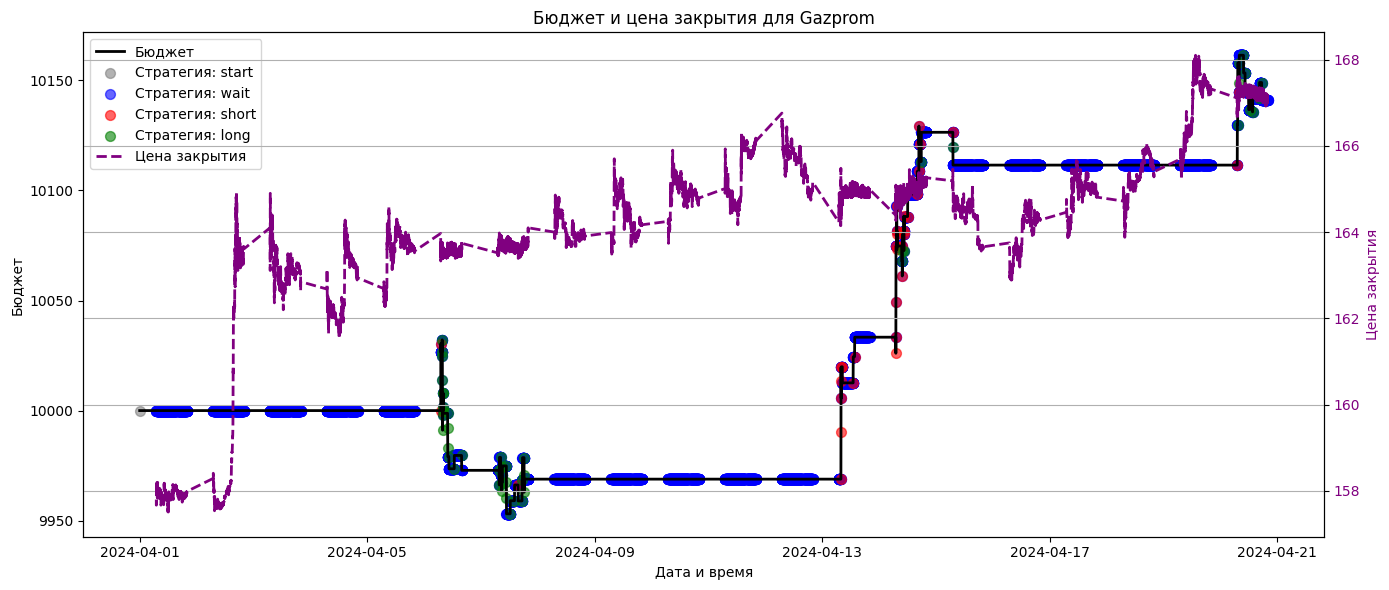

In [24]:
# История бюджета
history = results_news_big[0][0].copy()
history['datetime'] = pd.to_datetime(history['datetime'])
history = history.sort_values('datetime')

# Цены закрытия из исходного DataFrame (df) той же компании
# Найдём компанию
company_name = companies_names[0]
df_close = dfs_dict[company_name].copy()
df_close = df_close[df_close['utc'].between(history['datetime'].min(), history['datetime'].max())]
df_close = df_close.sort_values('utc')

fig, ax1 = plt.subplots(figsize=(14, 6))

# Первая ось — бюджет
ax1.set_xlabel('Дата и время')
ax1.set_ylabel('Бюджет', color='black')
ax1.plot(history['datetime'], history['budget'], label='Бюджет', color='black', linewidth=2)

# Точки стратегии
colors = {'start': 'gray', 'wait': 'blue', 'long': 'green', 'short': 'red'}
for strategy in history['strategy'].unique():
    mask = history['strategy'] == strategy
    ax1.scatter(history.loc[mask, 'datetime'], history.loc[mask, 'budget'],
                label=f'Стратегия: {strategy}', color=colors.get(strategy, 'black'), s=50, alpha=0.6)

ax1.tick_params(axis='y', labelcolor='black')

# Вторая ось — цена закрытия
ax2 = ax1.twinx()
ax2.set_ylabel('Цена закрытия', color='purple')
ax2.plot(df_close['utc'], df_close['close'], color='purple', linestyle='--', linewidth=2, label='Цена закрытия')
ax2.tick_params(axis='y', labelcolor='purple')

# Объединение легенд
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title(f'Бюджет и цена закрытия для {company_name}')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import datetime as dt

args = {"iterations" : 5000, 
        "depth" : 5, 
        "learning_rate" : 0.02, 
        "use_best_model" : True, 
        "l2_leaf_reg" : 100,
        "loss_function" : 'Logloss', 
        "eval_metric" : 'Logloss', 
        "cat_features" : [], 
        "class_weights" : [1, 0.4],
        "random_state" : 42,
        "early_stopping_rounds" : 500}

args1 = {"iterations" : 10000, 
        "depth" : 5, 
        "learning_rate" : 0.02, 
        "use_best_model" : True, 
        "l2_leaf_reg" : 200,
        "loss_function" : 'Logloss', 
        "eval_metric" : 'Logloss', 
        "cat_features" : [], 
        # "class_weights" : [1, 0.25],
        "random_state" : 42,
        "verbose" : 0, 
        "early_stopping_rounds" : 500}

# args0 = {"iterations" : 10000, 
#         "depth" : 5, 
#         "learning_rate" : 0.02, 
#         "use_best_model" : True, 
#         "l2_leaf_reg" : 200,
#         "loss_function" : 'Logloss', 
#         "eval_metric" : 'Logloss', 
#         "cat_features" : [], 
#         # "class_weights" : [0.25, 1],
#         "random_state" : 42,
#         "verbose" : 0, 
#         "early_stopping_rounds" : 500}

companies_names = ['Gazprom']
dfs = ["../../datasets/" + stock + '_1_min.csv' for stock in companies_names]
news_df = pd.read_csv('../../markettwits_with_hashtags.csv')

dfs_dict = dict()
start_dt = dt.datetime(2024, 1, 1)

for i in range(len(dfs)):
    findata = FinData(dfs[i])
    findata.restrict_time_down(start_dt)
    findata.insert_news_features(news_df, threshold=0.6)
    findata.make_both_binary_class_target()
    cat = findata.get_cat_features()
    num = findata.get_numeric_features()
    find = findata.df[findata.df['utc'].dt.hour >= 7][findata.df['utc'].dt.hour < 20]
    dfs_dict[companies_names[i]] = find 

backtest = Backtest(strategies=['long'], args=args, dfs=dfs_dict, features = [cat, num], comissions=[0.0004])

backtest_args = {
    'budget': 10000,
    'train_size': dt.timedelta(days=30),
    'val_size': dt.timedelta(days=5),
    'test_size':dt.timedelta(days=5),
    'start_dt_test': dt.datetime(2024, 4, 1),
    'end_dt_test': dt.datetime(2024, 4, 20),
    'args_for_strategies': {'long': (args1, 'direction_binary_0'), 'short': (args0, 'direction_binary_1')}
}

results_only_news = backtest.test_trading_long_short(**backtest_args)


KeyboardInterrupt: 

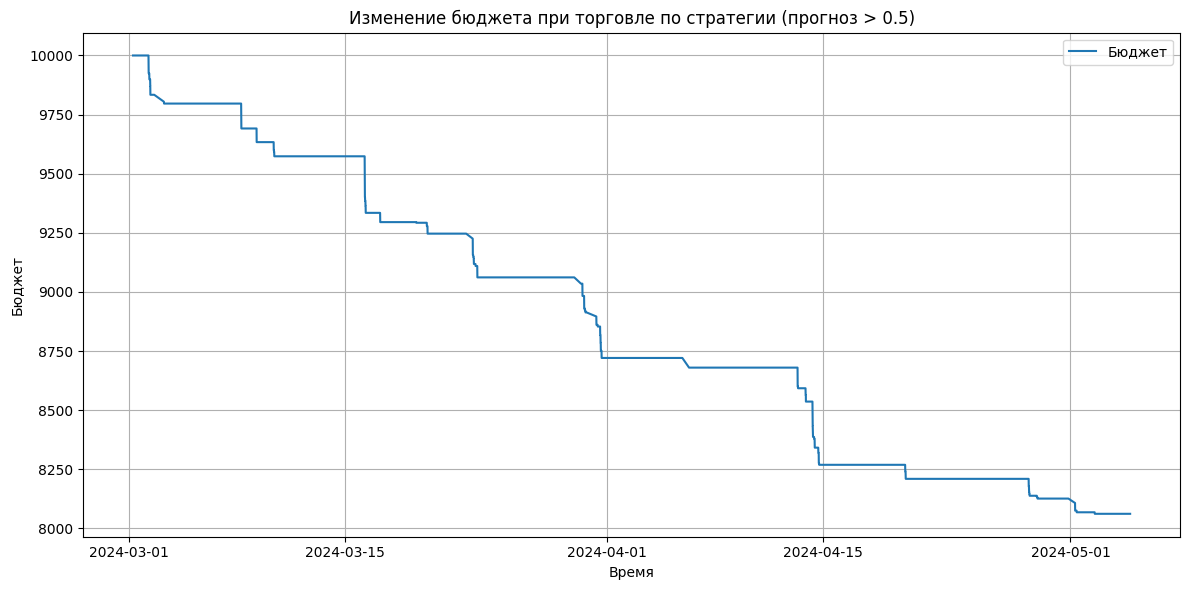

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузим данные
df = pd.read_csv("Gazprom.csv", parse_dates=["utc"])

# Отбрасываем последнюю строку, так как мы не знаем close_{t+1}
df = df[:-1].copy()

# Добавим колонку с ценой продажи — close_{t+1}
df['future_close'] = df['close'].shift(-1)

# Параметры
budget = 10_000
commission_rate = 0.0004  # 0.04%
budget_over_time = [budget]

for i, row in df.iterrows():
    proba = row['predicted_proba']
    buy_price = row['close']
    sell_price = row['future_close']

    if proba > 0.5:
        # Покупаем целое число акций
        num_shares = int(budget / (buy_price * (1 + commission_rate)))
        if num_shares > 0:
            # Сколько потратили с учетом комиссии
            total_cost = num_shares * buy_price * (1 + commission_rate)

            # Сколько выручили после продажи с учетом комиссии
            revenue = num_shares * sell_price * (1 - commission_rate)

            # Обновляем бюджет
            budget = budget - total_cost + revenue

    budget_over_time.append(budget)

# Построим график
plt.figure(figsize=(12, 6))
plt.plot(df["utc"], budget_over_time[1:], label="Бюджет")
plt.xlabel("Время")
plt.ylabel("Бюджет")
plt.title("Изменение бюджета при торговле по стратегии (прогноз > 0.5)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


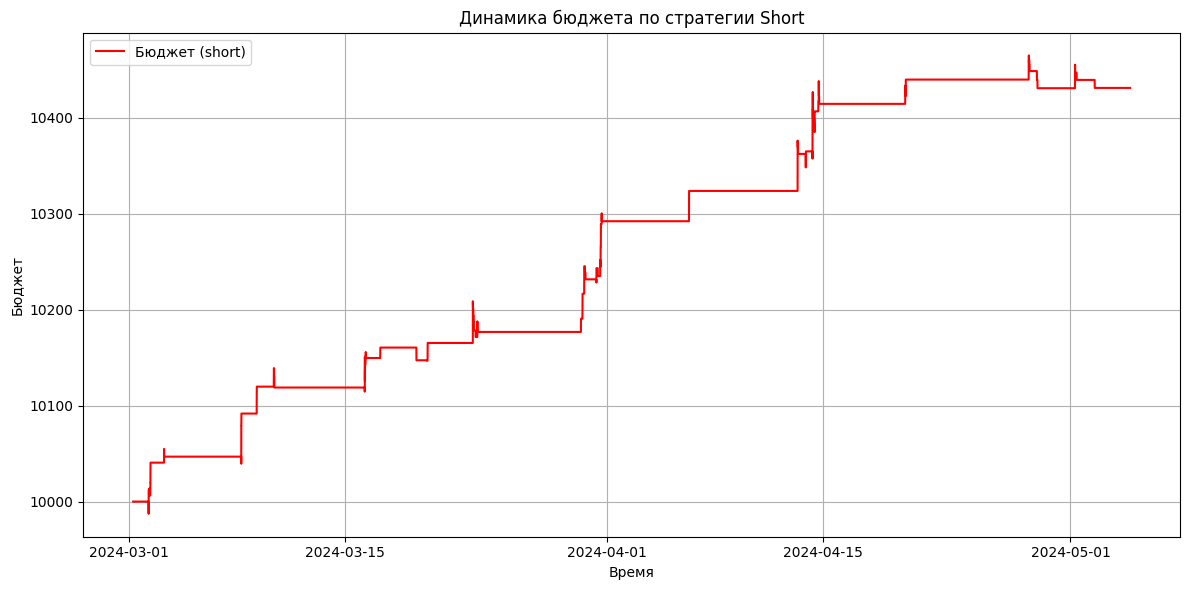

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных
df = pd.read_csv('Gazprom_short.csv', parse_dates=['utc'])

# Параметры
initial_budget = 10000
commission_rate = 0.0004

budget = initial_budget
budget_history = [budget]
timestamps = [df['utc'].iloc[0]]

for i in range(len(df) - 1):
    row = df.iloc[i]
    next_row = df.iloc[i + 1]

    price_now = row['close']
    price_next = next_row['close']
    proba = row['predicted_proba']

    if proba > 0.5:
        # Сколько акций можем "продать взаймы"
        n_shares = int(budget // price_now)
        if n_shares == 0:
            budget_history.append(budget)
            timestamps.append(next_row['utc'])
            continue

        # Доход от продажи по текущей цене
        proceeds = n_shares * price_now * (1 - commission_rate)

        # Сколько нужно потратить на обратный выкуп через минуту
        cost_to_cover = n_shares * price_next * (1 + commission_rate)

        # Изменяем бюджет
        budget += proceeds - cost_to_cover

    budget_history.append(budget)
    timestamps.append(next_row['utc'])

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(timestamps, budget_history, label='Бюджет (short)', color='red')
plt.xlabel('Время')
plt.ylabel('Бюджет')
plt.title('Динамика бюджета по стратегии Short')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
